In [1]:
#-*- coding:utf-8 -*-
from __future__ import print_function

import logging
from optparse import OptionParser
import sys
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import density
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import datasets
from sklearn import metrics
import os
import jieba
from sklearn.preprocessing import scale
import codecs
import pandas as pd
from sklearn.externals import joblib
from scipy.sparse import csr_matrix, hstack
import scipy
import pickle
import json
from matplotlib import pyplot
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text

In [2]:
data = '../data/'
pkls='../models/'
if not os.path.exists(pkls):
    os.mkdir(pkls)
stopwords_path='../utils/stopword_2792.txt'

# 1 载入数据

In [3]:
tra_contents=[]
tra_ids=[]
tra_labels=[]
with open(f'{data}train.json','r') as tra_f:
    for idx,each in enumerate(tra_f):
        samp=json.loads(each.strip())
        label=samp['label']#标签
        if label in ['video','epg']:
            content=samp['text']#内容

            tra_labels.append(label)
            tra_contents.append(content)

train_set={'content':tra_contents,
           'label':tra_labels}

train_df=pd.DataFrame(train_set)
print('Trainset Loaded')

Trainset Loaded


In [4]:
val_contents=[]
val_labels=[]
with open(f'{data}devel.json','r') as val_f:
    for idx,each in enumerate(val_f):
        samp=json.loads(each.strip())
        label=samp['label']#标签
        if label in ['video','epg']:
            content=samp['text']#内容

            val_labels.append(label)
            val_contents.append(content)

val_set={'content':val_contents,
           'label':val_labels}

val_df=pd.DataFrame(val_set)
print('Val-set Loaded')


Val-set Loaded


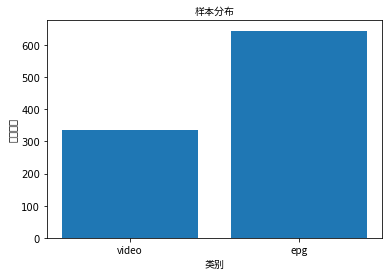

In [6]:
zhfont = mpl.font_manager.FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc')
#绘制柱状图

label2freq = {}
for label in labels:
    label2freq[label] = len(train_df.loc[train_df['label']==label])
#创建柱状图
#第一个参数为柱的横坐标
#第二个参数为柱的高度
#参数align为柱的对齐方式，以第一个参数为参考标准
pyplot.bar(range(2), [label2freq.get(label, 0) for label in labels], align='center')

#设置柱的文字说明
#第一个参数为文字说明的横坐标
#第二个参数为文字说明的内容
pyplot.xticks(range(2), labels,fontproperties=zhfont)

#设置横坐标的文字说明
pyplot.xlabel('类别',fontproperties=zhfont)
#设置纵坐标的文字说明
pyplot.ylabel('样本个数')
#设置标题
pyplot.title('样本分布',fontproperties=zhfont)
#绘图
pyplot.show()

# 2 生成词袋

In [7]:
#停用词
with open(stopwords_path,'r') as stw:
    stopwords=[x.strip() for x in stw]
my_stop_words = text.ENGLISH_STOP_WORDS.union(stopwords)
del stopwords

In [8]:
x_train_ = train_df['content']
x_val_ = val_df['content']
x_dataset=pd.concat([x_train_,x_val_],axis=0,ignore_index=True)

In [9]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
#     strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words=my_stop_words,
    ngram_range=(1, 2))
word_vectorizer.fit(x_dataset)

# 使用字符特征
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
#     strip_accents='unicode',
    stop_words=my_stop_words,
    analyzer='char',
    ngram_range=(1, 3))
char_vectorizer.fit(x_dataset)


joblib.dump(word_vectorizer,f'{pkls}vocab-wd_video-epg.pkl')
joblib.dump(char_vectorizer,f'{pkls}vocab-ch_video-epg.pkl')

['./svm_video-epg/vocab-ch_video-epg.pkl']

# 3 文本表示

In [10]:
%%time
#训练数据

y_train_= pd.Series(train_df['label'])
x_wd = word_vectorizer.transform(x_train_)
x_ch = char_vectorizer.transform(x_train_)
x = hstack([x_ch, x_wd])
x_train=scipy.sparse.csr_matrix(x)

#开发数据

y_val_= pd.Series(val_df['label'])

x_val_wd = word_vectorizer.transform(x_val_)

x_val_ch = char_vectorizer.transform(x_val_)
x_val = hstack([x_val_ch, x_val_wd])
x_val=scipy.sparse.csr_matrix(x_val)


CPU times: user 41.3 ms, sys: 96 µs, total: 41.4 ms
Wall time: 40.3 ms


In [11]:
%%time
#training

print("LinearSVC with L1-based feature selection ,BoW(word-level)")
clf = Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                    tol=1e-3))),
    ('classification', LinearSVC(penalty="l2"))])
clf.fit(x_train, y_train_)
joblib.dump(clf,f'{pkls}svm_video-epg.pkl')

LinearSVC with L1-based feature selection ,BoW(word-level)
CPU times: user 18 ms, sys: 7.84 ms, total: 25.8 ms
Wall time: 24.4 ms


### 评价方法

In [12]:
def evaluation_result(actual, pred):
    print('predict info:')
    print('f1-score:{0:.3f}'.format(metrics.f1_score(actual, pred,average='macro',labels=np.unique(pred))))
    print("accuracy:   %0.3f" % metrics.accuracy_score(actual, pred))
    print(metrics.classification_report(actual,pred,target_names=labels))

### 在开发集上测试

In [13]:
preds = clf.predict(x_val)
evaluation_result(y_val_, preds)

predict info:
f1-score:0.982
accuracy:   0.987
             precision    recall  f1-score   support

      video       0.95      1.00      0.97        36
        epg       1.00      0.98      0.99       121

avg / total       0.99      0.99      0.99       157



# 4 在线测试

In [23]:
%%time

from sklearn.externals import joblib
import pickle
import numpy as np
import jieba
from scipy.sparse import csr_matrix, hstack

def onlineTest(raw_query):
    text = [''.join([w for w in jieba.cut(raw_query)])]
    char_vectorizer=joblib.load(f'{pkls}vocab-ch_video-epg.pkl')
    test_ch = char_vectorizer.transform(text)
    word_vectorizer=joblib.load(f'{pkls}vocab-wd_video-epg.pkl')
    test_wd = word_vectorizer.transform(text)
    test_vec=hstack([test_ch, test_wd])
    test_vec=csr_matrix(test_vec)

    clf=joblib.load(f'{pkls}svm_video-epg.pkl')
    pred=clf.predict(test_vec)
    return pred.tolist()[0]

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 18.4 µs


In [24]:
onlineTest('中央台现在在放什么')

'epg'